# Machine Failure Prediction

The ability to predict machine failures, as well as the nature of the failure, is essential for Generation 4.0 industries. This is because the repair or replacement of a faulty machine can often be much more expensive than the cost of replacing a single component. Therefore, the installation of sensors that monitor the state of machines and collect the appropriate data can lead to significant savings for industries.

In this project, we use the AI4I Predictive Maintenance Dataset from the UCI Repository to conduct an analysis that aims to address the aforementioned needs. In particular, the work is presented in a manner that is consistent with a typical Machine Learning application. First, the dataset is explored to gain a deeper understanding of the ground truth. Then, some preprocessing techniques are applied to prepare the data for the algorithms that we will use to make our predictions. We consider two main tasks: the first is to determine whether a generic machine is about to fail, and the second is to determine the nature of the fault.

## Data Description 

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, the data provided by the UCI repository is a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of their knowledge. The dataset consists of 10 000 data points stored as rows with 14 features in columns.

* **UID**: This is a unique identifier that ranges from 1 to 10000.

* **Product ID**: This consisting of a letter L, M, or H for low (60% of all products), medium (30%) and high (10%) as product quality variants and a variant-specific serial number

* **Air temperature [K]**: This is the temperature of the air in the environment where the machine is operating. It is generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

* **Process temperature [K]**: This is the temperature of the process that the machine is performing. It is generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

* **Rotational speed [rpm]**: This is the speed at which the machine is rotating. It is calculated from a power of 2860 W, overlaid with a normally distributed noise.

* **Torque [Nm]**: This is the amount of force that the machine is applying. It is normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values.

* **Tool wear [min]**: This is the amount of time that the tool has been used. The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

* **Machine failure**: label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true. The machine failure consists of five independent failure modes:

1. **Tool Wear Failure (TWF)**: The tool will be replaced or fail at a randomly selected tool wear time between 200 and 240 minutes.

2. **Heat Dissipation Failure (HDF)**: Heat dissipation causes a process failure if the difference between the air and process temperatures is below 8.6 K and the tool's rotational speed is below 1380 rpm.

3. **Power Failure (PWF)**:The product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

4. **Overstrain Failure (OSF)**: If the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

5. **Random Failures (RNF)**: Each process has a chance of 0.1% to fail regardless of its process parameters.



If at least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv(r"C:\AI4I Predictive Maintenance.csv")

In [3]:
# Check the head of the data
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Check the tail of the data
df.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,No Failure


In [5]:
# Check the shape of the data
df.shape

(10000, 10)

In [6]:
# Get some more information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [7]:
# Count the number of duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 0


In [8]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

**Quick insights:**

* There are 10000 instances in the dataset
* There is no missing data
* There are no duplicate values
* There are 3 categorical features and 7 numerical features
* Product ID is an identification number and UDI is an index number. So, both can be removed

In [9]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis = 1, inplace = True)

In [10]:
df.shape

(10000, 8)

In [11]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [12]:
# Rename features
df.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

converting the datatype of Rotational speed [rpm] and Tool wear [min] to float

In [13]:
# Converting dtype to float
df['Rotational speed']=df['Rotational speed'].astype('float64')
df['Tool wear']=df['Tool wear'].astype('float64')

In [14]:
df.dtypes

Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed       float64
Torque                 float64
Tool wear              float64
Target                   int64
Failure Type            object
dtype: object

In [15]:
# descriptive statistics for the DataFrame
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


## Exploratory Data Analysis (EDA)

In [16]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

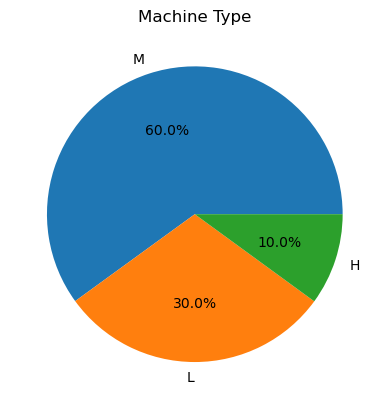

In [17]:
plt.pie(df['Type'].value_counts(), labels=df['Type'].unique(), autopct='%1.1f%%')
plt.title('Machine Type')
plt.show()

<AxesSubplot:xlabel='Type', ylabel='count'>

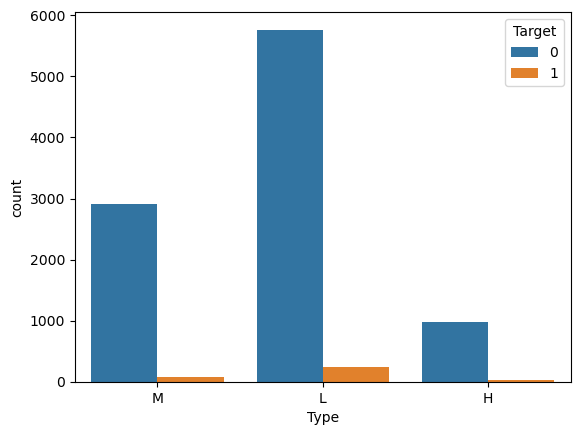

In [18]:
sns.countplot(x='Type', hue='Target', data=df)

In [19]:
df['Target'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Target, dtype: float64

<AxesSubplot:xlabel='Target', ylabel='count'>

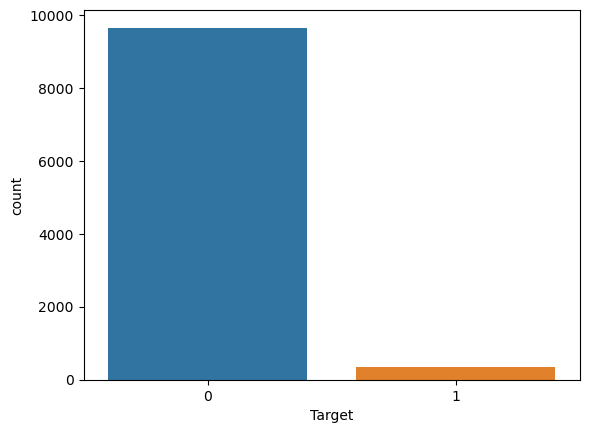

In [20]:
sns.countplot(x=df['Target'])

In [21]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

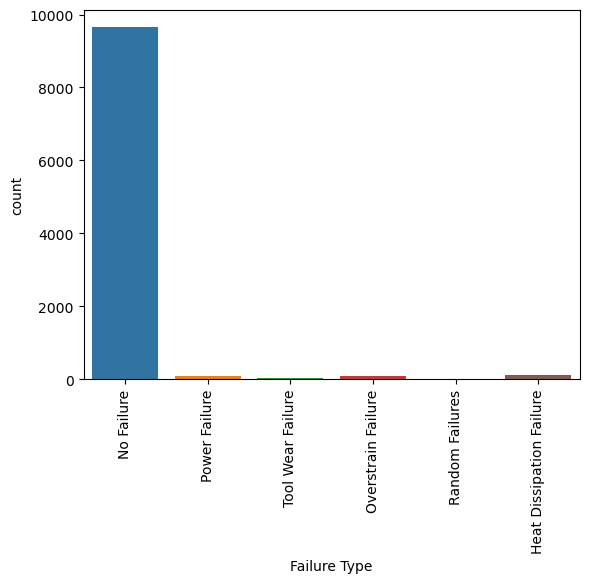

In [22]:
sns.countplot(x=df['Failure Type'])
plt.xticks(rotation=90)
plt.show()

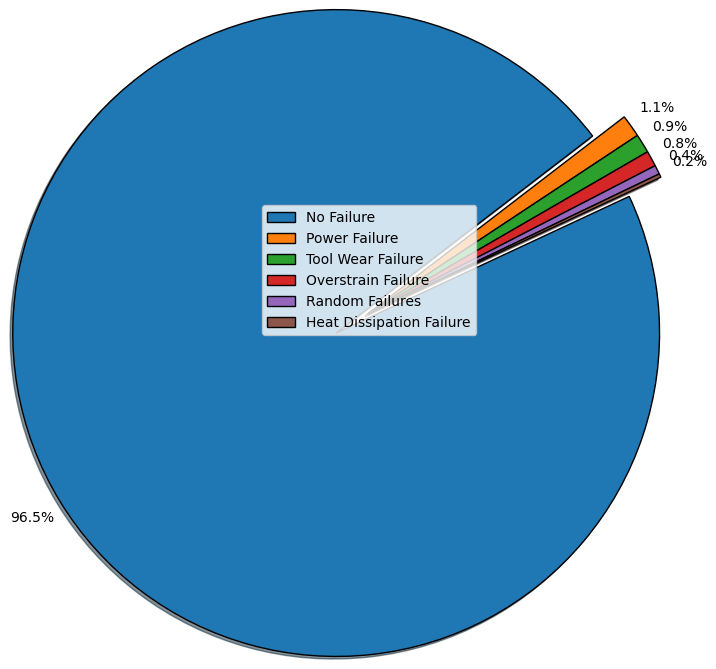

In [23]:
plt.figure(figsize=(4,3))
explode = (0.4, 0, 0, 0, 0, 0) 
plt.pie(df['Failure Type'].value_counts(), explode=explode, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=3.5)
plt.legend(df['Failure Type'].unique())
plt.show()

**Numerical Features**

In [24]:
df.columns

Index(['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear', 'Target', 'Failure Type'],
      dtype='object')

In [25]:
# numerical features
num_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
num_features

['Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear',
 'Target']

In [26]:
print('Numerical features count:',len(num_features))

Numerical features count: 6


In [27]:
# discreate features
dis_features = [feature for feature in num_features if df[feature].nunique()<10]
dis_features

['Target']

In [28]:
#continous features
con_features = [feature for feature in num_features if feature not in dis_features]
con_features

['Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear']

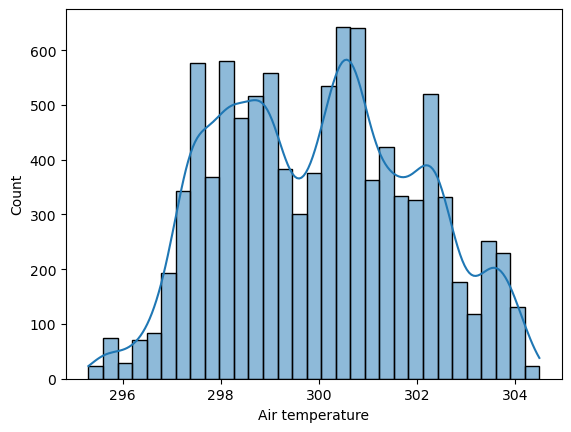

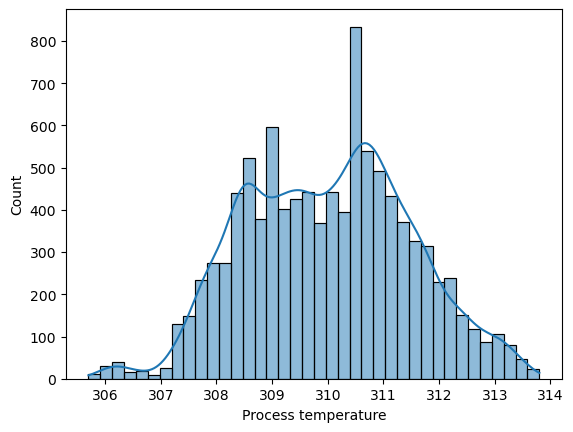

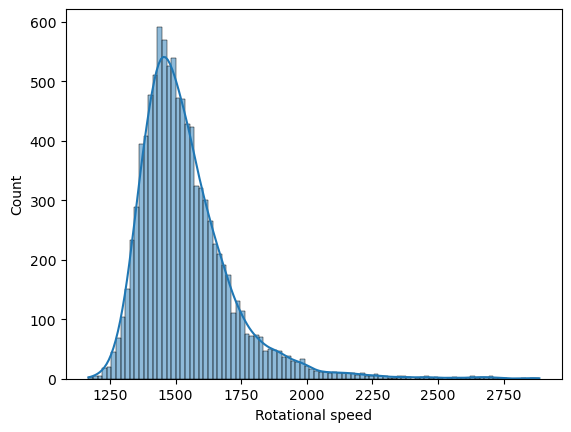

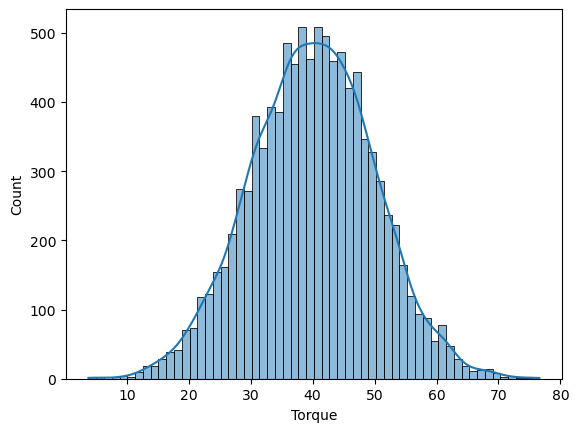

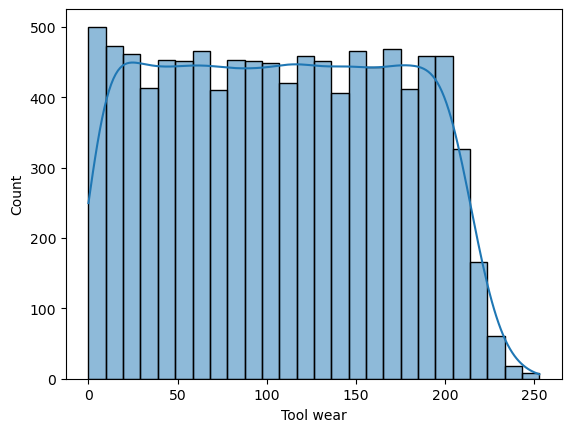

In [29]:
for feature in con_features:
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.show() 

**Categorical Features**

In [30]:
#categorical features
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
cat_features

['Type', 'Failure Type']

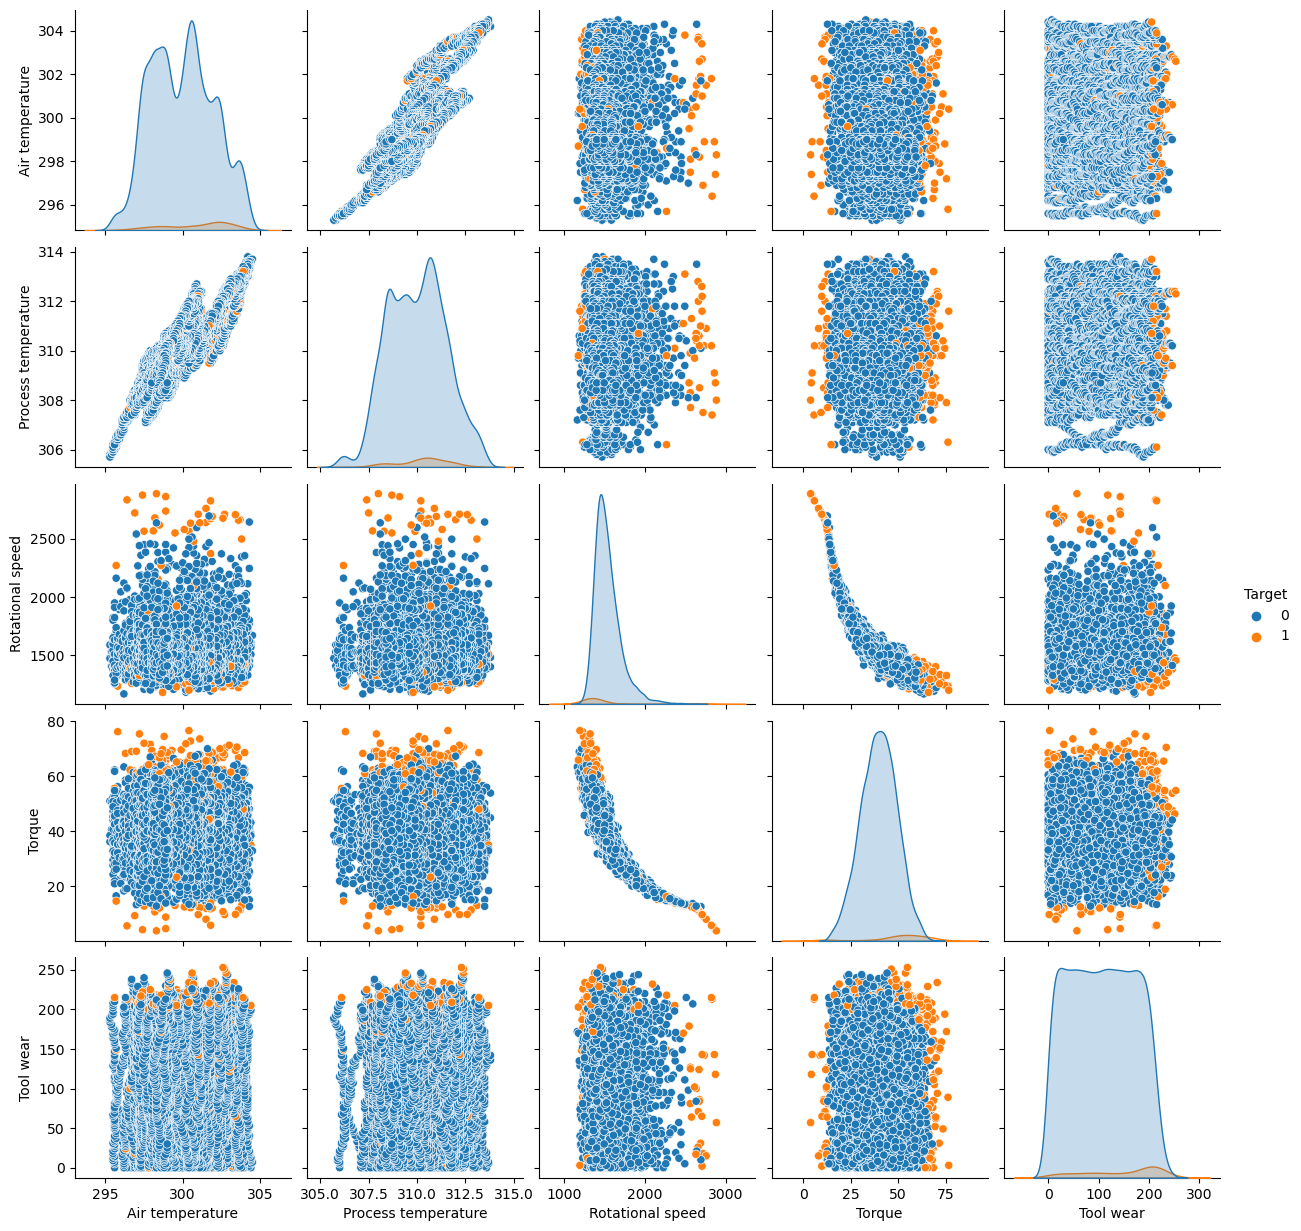

In [31]:
sns.pairplot(df,hue = "Target")
plt.show()

**Insights:**

* Torque and rotational speed are highly correlated.
* Process temperature and air temperature are also highly correlated.

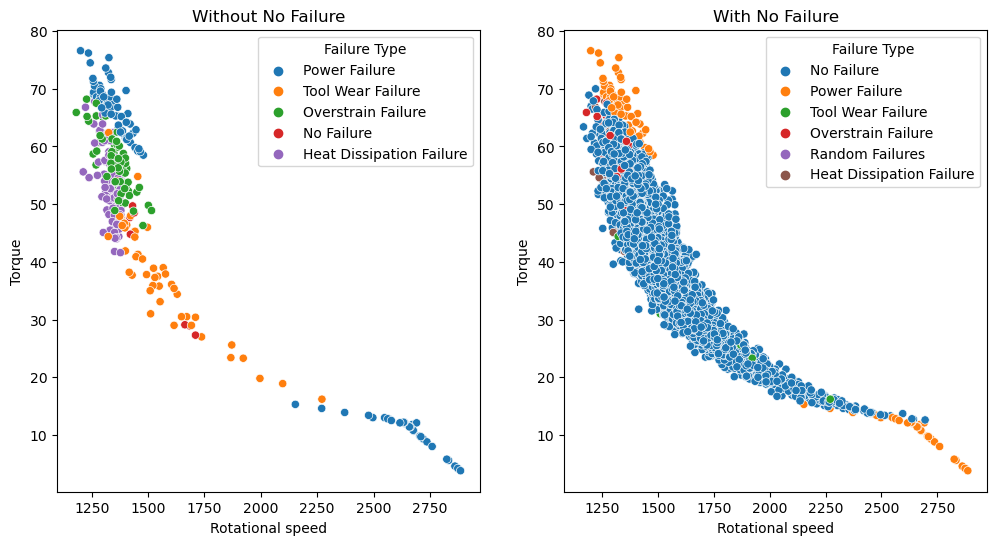

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.scatterplot(data=df[df['Target']==1], x='Rotational speed', y='Torque', hue='Failure Type')
plt.title('Without No Failure')
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type')
plt.title('With No Failure')
plt.show()

**Insights**
* Power failures occur at both low and high rotational speeds, with the highest occurrence at speeds over 2500rpm and torques below 15Nm.
* Tool wear is the only failure type that occurs between torques of 16Nm and 41Nm.
* Overstrain failures occur at torques ranging from around 47 to 68Nm and rotational speeds of approximately 1200 to 1500rpm.
* Heat dissipation failures have a smaller torque range but a larger rotational speed range compared to overstrain failures.

## Preprocessing

In [33]:
df.isnull().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Failure Type           0
dtype: int64

**Outliers Detection**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

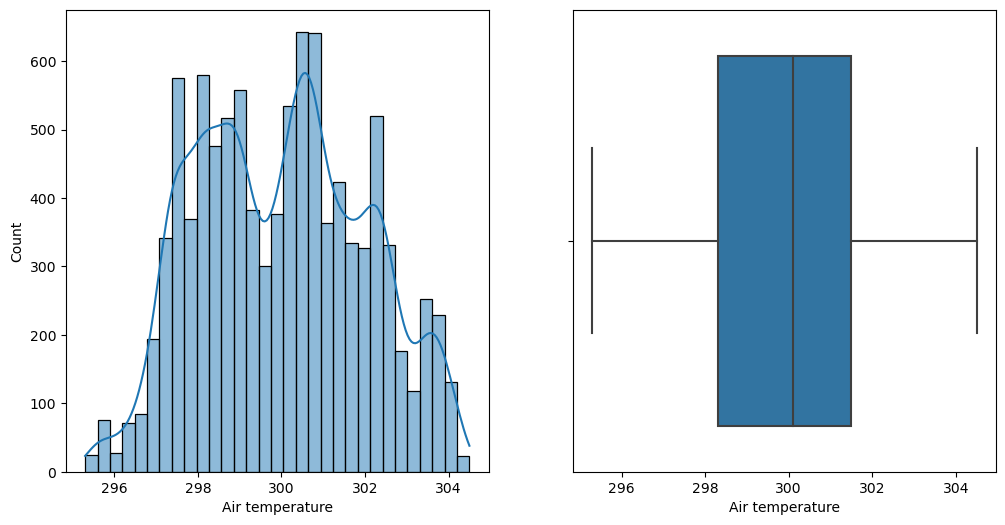

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


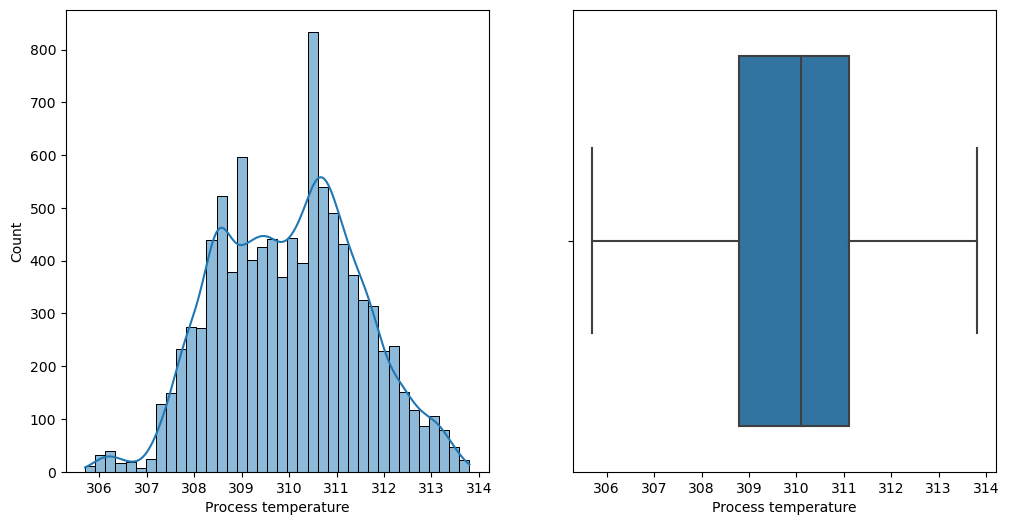

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


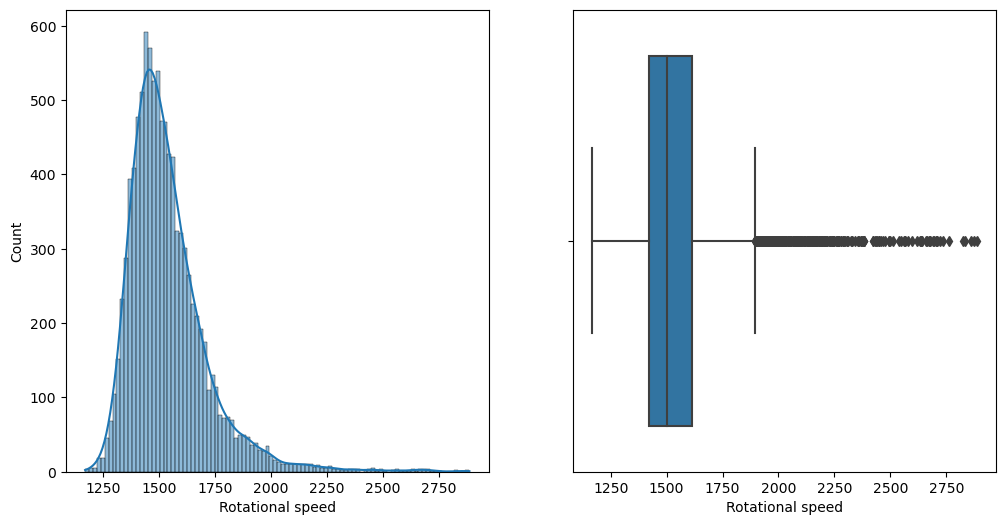

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


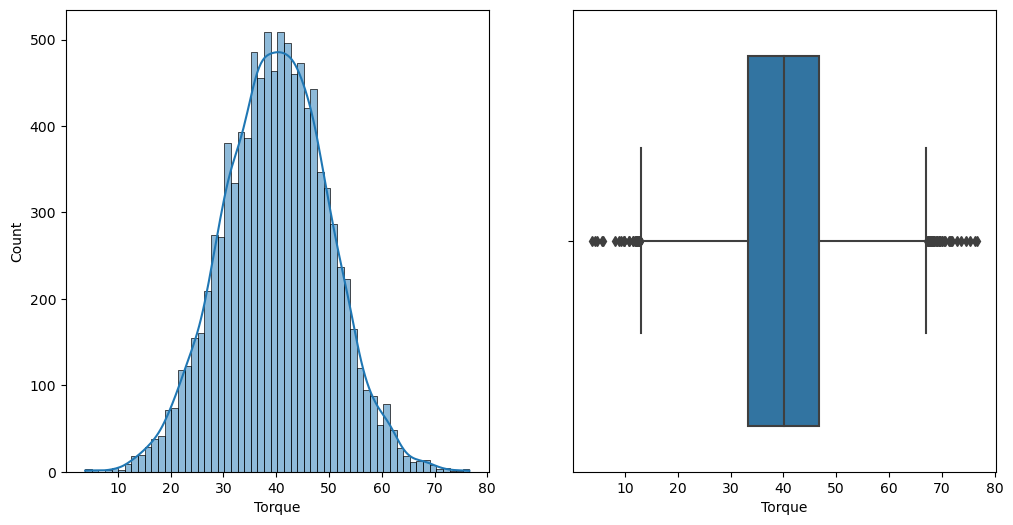

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


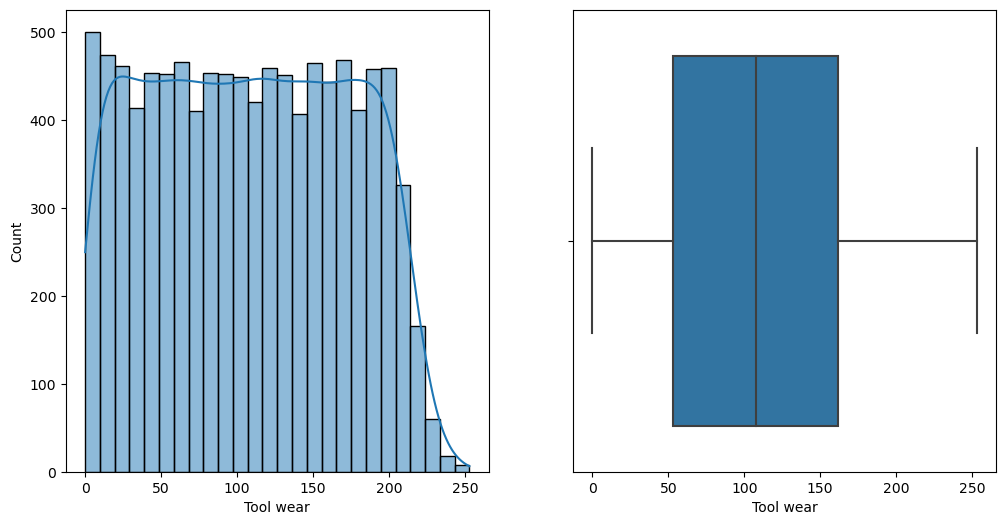

In [34]:
plt.figure(figsize=(12,6))
for feature in con_features:
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.subplot(1,2,2)
    sns.boxplot(df[feature])
    plt.show()

**Insights**

* For Torque, the outliers identified using boxplots may not be true outliers as the distribution is Gaussian, and using the 3σ rule would be more appropriate.
* For Rotational Speed, the distribution is skewed, and it's likely that the few observations with high Rotational Speed are going to fail.
* We are keeping the outliers for now and will decide whether to take action after considering other aspects.

**Target anomalies**

In [35]:
df[df['Failure Type'] == 'Random Failures']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1221,M,297.0,308.3,1399.0,46.4,132.0,0,Random Failures
1302,L,298.6,309.8,1505.0,45.7,144.0,0,Random Failures
1748,H,298.4,307.7,1626.0,31.1,166.0,0,Random Failures
2072,L,299.6,309.5,1570.0,35.5,189.0,0,Random Failures
2559,L,299.3,309.0,1447.0,50.4,140.0,0,Random Failures
3065,M,300.1,309.2,1687.0,27.7,95.0,0,Random Failures
3452,H,301.6,310.5,1602.0,32.3,2.0,0,Random Failures
5471,L,302.7,312.3,1346.0,61.2,170.0,0,Random Failures
5489,L,302.6,312.1,1499.0,35.0,215.0,0,Random Failures
5495,H,302.9,312.5,1357.0,55.0,12.0,0,Random Failures


Target feature is not set to 1 when the failure is random (RNF), making it unclear which failure mode caused the process to fail. Since this occurs in only 18 observations and is random in nature, it is not predictable. So they were removed.

In [36]:
df.drop(index = df[df['Failure Type'] == 'Random Failures'].index, axis=0, inplace = True)

In [37]:
df[(df['Target']==1) & (df['Failure Type']=='No Failure')]

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439.0,45.2,40.0,1,No Failure
2749,M,299.7,309.2,1685.0,28.9,179.0,1,No Failure
4044,M,301.9,310.9,1419.0,47.7,20.0,1,No Failure
4684,M,303.6,311.8,1421.0,44.8,101.0,1,No Failure
5536,M,302.3,311.8,1363.0,54.0,119.0,1,No Failure
5941,L,300.6,310.7,1438.0,48.5,78.0,1,No Failure
6478,L,300.5,309.8,1663.0,29.1,145.0,1,No Failure
8506,L,298.4,309.6,1710.0,27.3,163.0,1,No Failure
9015,L,297.2,308.1,1431.0,49.7,210.0,1,No Failure


9 observations with Machine Failure set to 1 and all types of failures set to 0 were found, so they were removed as it's unclear if a failure occurred or not.

In [38]:
df.drop(index = df[(df['Target']==1) & (df['Failure Type']=='No Failure')].index, axis=0, inplace = True)

In [39]:
df.shape

(9973, 8)

**Resampling with SMOTE**

In [40]:
# Portion of df where there is a failure and percentage of failure
n = df.shape[0]
idx_fail = df[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))

Failures percentage in data: 3.31


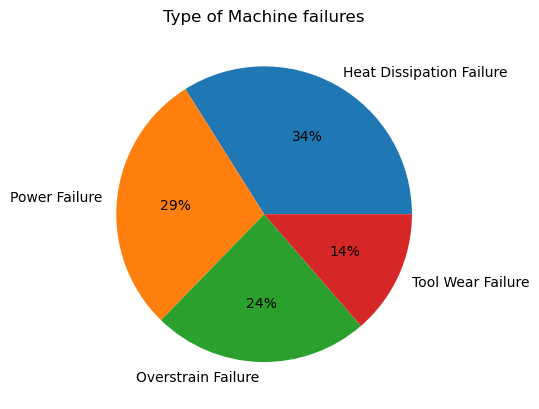

In [41]:
# Pie plot
plt.title('Type of Machine failures')
plt.pie(x=df_fail_percentage, labels=df_fail_percentage.index, colors=sns.color_palette('tab10'), autopct='%.0f%%')
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

It is based on the assumption that 80% of the resampled dataframe should be comprised of the "No Failure" class, since this is the majority class in the original dataset. 

In [43]:
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = df_res_fail['Failure Type'].value_counts()*100/df_res_fail.shape[0]
print('SMOTE Resampled Failures percentage:',round(df_res_fail.shape[0]*100/df_res.shape[0],2))

SMOTE Resampled Failures percentage: 20.01


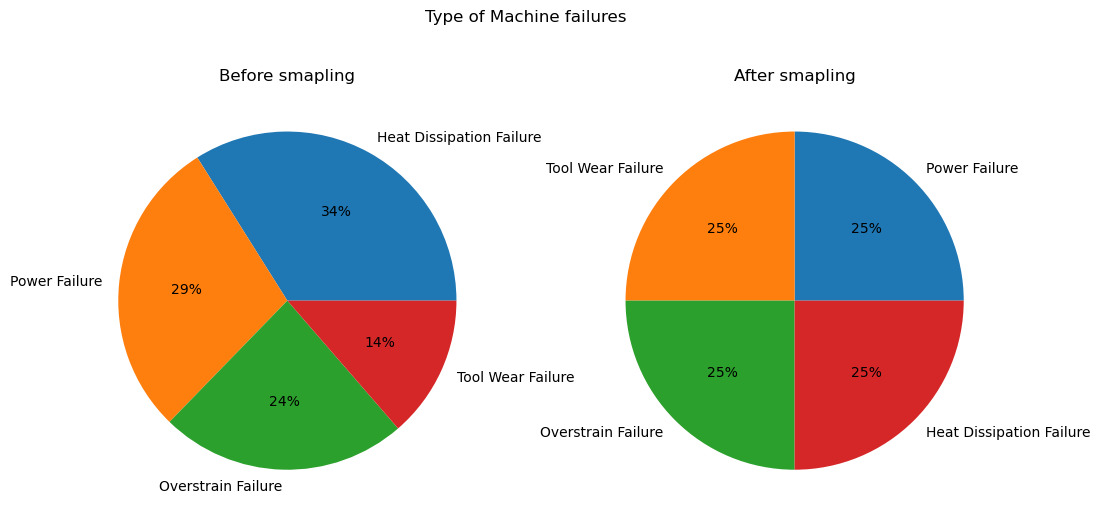

In [44]:
plt.figure(figsize=(12,6))
plt.suptitle('Type of Machine failures')
plt.subplot(1,2,1)
plt.title('Before smapling')
plt.pie(x=df_fail_percentage, labels=df_fail_percentage.index, colors=sns.color_palette('tab10'), autopct='%.0f%%')
plt.subplot(1,2,2)
plt.title('After smapling')
plt.pie(x=fail_res_percentage, labels=fail_res_percentage.index, colors=sns.color_palette('tab10'), autopct='%.0f%%')
plt.show()

**Ordinal Encoding**

Since 'Type' is an ordinal feature and 'Failure Type' must be represented in one column, we use OrdinalEncoder to encode them as numerical values.
The mapping follows this scheme:
* Type: {L=0, M=1, H=2}
* Failure Type: {No Failure=0, Power Failure=1, Overstrain Failure=2, Heat Dissipation Failure=3, Tool Wear Failure=4}

In [45]:
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], ['No Failure', 'Power Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Tool Wear Failure']])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

**Scaling data**

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df[con_features] = sc.fit_transform(df[con_features]) 

In [47]:
df.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Type,Failure Type
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0,1.0,0.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0,0.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0,0.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0,0.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0,0.0,0.0


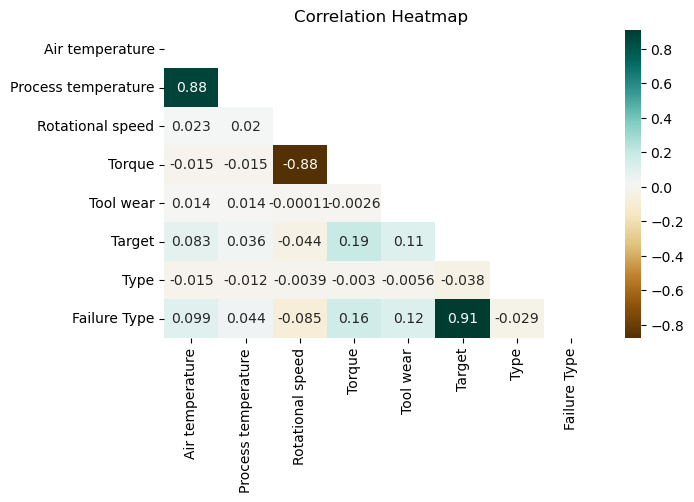

In [48]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
corr = df.corr()
sns.heatmap(corr, mask=np.triu(corr.values), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap shows that the features "Process temperature" and "Air temperature" are positively correlated, and "Torque" and "Rotational speed" are negatively correlated. The dataset description tells us that the PWF failure occurs if the product between "Torque" and "Rotational speed" is in a certain range of values, and the HDF failure occurs when the difference between "Air temperature" and "Process temperature" exceeds a certain value. This means that these features are important for predicting failures. Therefore, completely deleting these columns would be a bad choice because important information would be lost. It is better to keep all of the features and use them to train a machine learning model to predict failures.

## Binary Classification 

The aim of this section is to determine the optimal model for binary classification, with the objective of predicting whether or not there will be a machine failure.

In [49]:
from sklearn.model_selection import train_test_split

X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

models = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Neighbors Classifier', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('XGBClassifier', XGBClassifier()),
]


for name, model in models:
    # Train model
    model.fit(X_train, y_train)

    # Test model
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} accuracy: {accuracy:.3f}')
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'{name} ROC AUC score: {roc_auc:.3f}')

    print(f'Confusion Matrix for {name}:')
    print(confusion_matrix(y_test, y_pred))

    print(f'Classification Report for {name}:')
    print(classification_report(y_test, y_pred))

Logistic Regression accuracy: 0.974
Logistic Regression ROC AUC score: 0.584
Confusion Matrix for Logistic Regression:
[[1933    3]
 [  49   10]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1936
           1       0.77      0.17      0.28        59

    accuracy                           0.97      1995
   macro avg       0.87      0.58      0.63      1995
weighted avg       0.97      0.97      0.97      1995

K-Neighbors Classifier accuracy: 0.975
K-Neighbors Classifier ROC AUC score: 0.658
Confusion Matrix for K-Neighbors Classifier:
[[1926   10]
 [  40   19]]
Classification Report for K-Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1936
           1       0.66      0.32      0.43        59

    accuracy                           0.97      1995
   macro avg       0.82      0.66      0.71      1995
wei

Based on the accuracy results, it appears that both Random Forest and XGBClassifier models demonstrate high accuracy performance with scores of 0.990 and 0.989 respectively.

In [51]:
from sklearn.model_selection import cross_val_score, KFold

models = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Neighbors Classifier', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('XGBClassifier', XGBClassifier()),
]

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    # Perform cross-validation
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

    # Evaluate results
    print(f'{name} cross-validation results: {cv_results}')
    print(f'{name} mean accuracy: {cv_results.mean():.3f}')
    print(f'{name} standard deviation: {cv_results.std():.3f}\n')

Logistic Regression cross-validation results: [0.97393484 0.97493734 0.96942356 0.97141424 0.96489468]
Logistic Regression mean accuracy: 0.971
Logistic Regression standard deviation: 0.004

K-Neighbors Classifier cross-validation results: [0.97493734 0.97794486 0.9754386  0.97642929 0.96990973]
K-Neighbors Classifier mean accuracy: 0.975
K-Neighbors Classifier standard deviation: 0.003

Random Forest cross-validation results: [0.99047619 0.98646617 0.98145363 0.98395186 0.98094283]
Random Forest mean accuracy: 0.985
Random Forest standard deviation: 0.004

Gaussian Naive Bayes cross-validation results: [0.96942356 0.9593985  0.960401   0.95837513 0.9553661 ]
Gaussian Naive Bayes mean accuracy: 0.961
Gaussian Naive Bayes standard deviation: 0.005

SVM cross-validation results: [0.97844612 0.97694236 0.97443609 0.97542628 0.96389168]
SVM mean accuracy: 0.974
SVM standard deviation: 0.005

XGBClassifier cross-validation results: [0.98947368 0.98847118 0.98245614 0.98495486 0.98294885]
XG

In [52]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for each model
param_grid = {}

# Random Forest
param_grid['Random Forest'] = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# XGBClassifier
param_grid['XGBClassifier'] = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1, 5],
}

# Loop through Random Forest and XGBClassifier models
for name, model in [('Random Forest', RandomForestClassifier()), ('XGBClassifier', XGBClassifier())]:
    # Define the GridSearchCV object
    if name == 'XGBClassifier':
        params = {'objective': 'binary:logistic'}
        model.set_params(**params)
    grid = GridSearchCV(model, param_grid=param_grid[name], scoring='accuracy', cv=5, n_jobs=-1)

    # Train the GridSearchCV object
    grid.fit(X_train, y_train)

    # Print the best hyperparameters and accuracy score
    print(f'Best hyperparameters for {name}: {grid.best_params_}')
    print(f'{name} accuracy: {grid.best_score_:.3f}')

Best hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest accuracy: 0.985
Best hyperparameters for XGBClassifier: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBClassifier accuracy: 0.987


XGB Classifier model achieved a slightly higher accuracy score of 0.987 so it used to build the binary classification model.

## Multi-class Classification

This section aims to identify the type of failure in a multiclass classification problem, assuming that each sample is assigned to a single label. To account for class imbalance (80% working machines and 20% that fail), we set the "average" parameter to "weighted" when calculating performance metrics. This means that scores are calculated by taking the weighted average of the scores for each class, proportional to the number of samples in each class. For our multiclass classification model, we used the "OnevsRest" approach, which trains a single classifier per class. In this approach, positive samples belong to a specific class while all other samples are considered negatives. This strategy is computationally efficient compared to other approaches.

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type'] 

# Define models
models = [
    ('Logistic Regression', OneVsRestClassifier(LogisticRegression())),
    ('K-Neighbors Classifier', OneVsRestClassifier(KNeighborsClassifier())),
    ('Random Forest', OneVsRestClassifier(RandomForestClassifier())),
    ('Gaussian Naive Bayes', OneVsRestClassifier(GaussianNB())),
    ('SVM', OneVsRestClassifier(SVC())),
    ('XGBClassifier', OneVsRestClassifier(XGBClassifier())),
]

# Train and evaluate models
for name, model in models:
    # Train model
    model.fit(X_train, y_train)

    # Test model
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
        
    print(f'{name} accuracy: {accuracy:.3f}')
    print(f'{name} ROC AUC score: {roc_auc:.3f}')
    print(f'{name} precision: {precision:.3f}')
    print(f'{name} recall: {recall:.3f}')
    print(f'{name} F1 score: {f1:.3f}')

    print(f'Confusion Matrix for {name}:')
    print(confusion_matrix(y_test, y_pred))

Logistic Regression accuracy: 0.974
Logistic Regression ROC AUC score: 0.584
Logistic Regression precision: 0.969
Logistic Regression recall: 0.974
Logistic Regression F1 score: 0.966
Confusion Matrix for Logistic Regression:
[[1933    3]
 [  49   10]]
K-Neighbors Classifier accuracy: 0.975
K-Neighbors Classifier ROC AUC score: 0.658
K-Neighbors Classifier precision: 0.970
K-Neighbors Classifier recall: 0.975
K-Neighbors Classifier F1 score: 0.971
Confusion Matrix for K-Neighbors Classifier:
[[1926   10]
 [  40   19]]
Random Forest accuracy: 0.987
Random Forest ROC AUC score: 0.829
Random Forest precision: 0.986
Random Forest recall: 0.987
Random Forest F1 score: 0.986
Confusion Matrix for Random Forest:
[[1930    6]
 [  20   39]]
Gaussian Naive Bayes accuracy: 0.969
Gaussian Naive Bayes ROC AUC score: 0.615
Gaussian Naive Bayes precision: 0.962
Gaussian Naive Bayes recall: 0.969
Gaussian Naive Bayes F1 score: 0.965
Confusion Matrix for Gaussian Naive Bayes:
[[1920   16]
 [  45   14]]


The Random Forest model had the highest accuracy of 0.989, followed closely by the XGBClassifier model with an accuracy of 0.989. These models performed well in correctly classifying the failure type of the equipment based on the given features.

The ROC AUC score is a metric that measures the performance of the model in distinguishing between the positive and negative classes. The XGBClassifier model had the highest ROC AUC score of 0.888, followed by the Random Forest model with a score of 0.855. These models had high AUC scores, indicating good performance in correctly identifying the positive class.

In [54]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

# Define models
models = [
    ('Logistic Regression', OneVsRestClassifier(LogisticRegression())),
    ('K-Neighbors Classifier', OneVsRestClassifier(KNeighborsClassifier())),
    ('Random Forest', OneVsRestClassifier(RandomForestClassifier())),
    ('Gaussian Naive Bayes', OneVsRestClassifier(GaussianNB())),
    ('SVM', OneVsRestClassifier(SVC())),
    ('XGBClassifier', OneVsRestClassifier(XGBClassifier())),
]

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models using k-fold cross-validation
for name, model in models:
    accuracy_scores = []
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        # Split data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train model
        model.fit(X_train, y_train)

        # Test model
        y_pred = model.predict(X_test)

        # Evaluate model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

        # Save scores for current fold
        accuracy_scores.append(accuracy)
        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Compute mean scores across all folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores) 
    
    print(f'{name} mean accuracy: {mean_accuracy:.3f}')
    print(f'{name} mean precision: {mean_precision:.3f}')
    print(f'{name} mean recall: {mean_recall:.3f}')
    print(f'{name} mean F1 score: {mean_f1:.3f}')

Logistic Regression mean accuracy: 0.973
Logistic Regression mean precision: 0.969
Logistic Regression mean recall: 0.973
Logistic Regression mean F1 score: 0.964
K-Neighbors Classifier mean accuracy: 0.974
K-Neighbors Classifier mean precision: 0.970
K-Neighbors Classifier mean recall: 0.974
K-Neighbors Classifier mean F1 score: 0.967
Random Forest mean accuracy: 0.985
Random Forest mean precision: 0.984
Random Forest mean recall: 0.985
Random Forest mean F1 score: 0.982
Gaussian Naive Bayes mean accuracy: 0.962
Gaussian Naive Bayes mean precision: 0.963
Gaussian Naive Bayes mean recall: 0.962
Gaussian Naive Bayes mean F1 score: 0.959
SVM mean accuracy: 0.973
SVM mean precision: 0.971
SVM mean recall: 0.973
SVM mean F1 score: 0.963
XGBClassifier mean accuracy: 0.987
XGBClassifier mean precision: 0.984
XGBClassifier mean recall: 0.987
XGBClassifier mean F1 score: 0.985


XGBClassifier and Random Forest have the highest accuracy, precision, recall, and F1 scores.

In [55]:
# Define parameter grid for each model
param_grid = {}

# Random Forest
param_grid['Random Forest'] = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

# XGBClassifier
param_grid['XGBClassifier'] = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [None, sum(y_train == 0) / sum(y_train == 1)]
}

# Loop through Random Forest and XGBClassifier models
for name, model in [('Random Forest', RandomForestClassifier()), ('XGBClassifier', XGBClassifier())]:
    # Define the GridSearchCV object
    if name == 'XGBClassifier':
        params = {'objective': 'binary:logistic'}
        model.set_params(**params)
    grid = GridSearchCV(model, param_grid=param_grid[name], scoring='accuracy', cv=5, n_jobs=-1)

    # Train the GridSearchCV object
    grid.fit(X_train, y_train)

    # Print the best hyperparameters and accuracy score
    print(f'Best hyperparameters for {name}: {grid.best_params_}')
    print(f'{name} accuracy: {grid.best_score_:.3f}')
    
    # Evaluate performance on test set with "weighted" average parameter
    y_pred = grid.predict(X_test)
    print(f'{name} test set precision: {precision_score(y_test, y_pred, average="weighted", zero_division=0):.3f}')
    print(f'{name} test set recall: {recall_score(y_test, y_pred, average="weighted", zero_division=0):.3f}')
    print(f'{name} test set f1-score: {f1_score(y_test, y_pred, average="weighted", zero_division=0):.3f}')

Best hyperparameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest accuracy: 0.972
Random Forest test set precision: 0.971
Random Forest test set recall: 0.978
Random Forest test set f1-score: 0.973
Best hyperparameters for XGBClassifier: {'gamma': 0, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': None}
XGBClassifier accuracy: 0.971
XGBClassifier test set precision: 0.976
XGBClassifier test set recall: 0.983
XGBClassifier test set f1-score: 0.979


Based on the evaluation metrics on the test set, it can be concluded that the XGBClassifier outperformed the Random Forest model. Although the XGBClassifier had a slightly lower accuracy than the Random Forest, it had higher precision, recall, and F1-score, which are important metrics in classification problems. Therefore, the XGBClassifier is the preferred choice for building the multi-class classification model.

## Conclusion

This project aimed to predict machine failures and their types using two classification tasks. To ensure optimal model performance, a thorough data preprocessing and exploratory data analysis (EDA) were conducted. In preprocessing phase, some ambiguous samples were removed, imbalanced data was addressed by applying the SMOTE resampling technique. The ordinal feature was encoded as numerical values using OrdinalEncoder, and the categorical columns were encoded using LabelEncoder. Column scaling was also performed using StandardScaler. Important features were identified using the correlation heatmap, and were kept in the final models after cross-validation and hyperparameter tuning. The XGBoost model outperformed the Random Forest model in terms of precision, recall, and F1-score, making it the best choice for both classification tasks. However, the XGBoost model had a longer response time, which increased further in the multi-class classification task.

In conclusion, the XGBoost model was selected as the best model for predicting machine failures and their types, taking into consideration both its performance and response time.